In [12]:
import math
import os
import site
import sqlite3
import sys
from time import sleep

import logzero
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import SARIMAX, VAR, acf, adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from tqdm import tqdm_notebook as tqdm
from yaml import dump, load, safe_load

In [31]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 30, 25
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
log_path = "logs/"
log_file = "ts_arima.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [4]:
sys.path.append("../../sql")
import queries

In [5]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_paths"]["db_path"]

city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "-" + state + ".db"

db_table1 = configs["table_names"]["db_table1"]
db_table2 = configs["table_names"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [6]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

In [7]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['91708']


In [8]:
zipcode_index = 0
params = {"zipcode": distinct_zipcodes[zipcode_index]}

select_nsr_rows = f"""
SELECT date_time,
-- year, month, day, 
-- zipcode,
-- Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature,
Relative_Humidity,
Precipitable_Water,
-- Wind_Direction,
Wind_Speed
from nsrdb
where zipcode = :zipcode
-- and not (month = 2 and day = 29)
-- and year = 2000
;
"""

df = pd.read_sql(
    select_nsr_rows,
    conn,
    params=params,
    index_col="date_time",
    parse_dates=["date_time"],
)

df.sort_index(axis=0, inplace=True)
columns = df.columns.tolist()
# df.head(5)

In [45]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Clearsky_DNI,201624.0,363.234789,397.919947,0.000,0.000,0.000,811.000,1033.000
DNI,201624.0,289.478227,375.068854,0.000,0.000,0.000,697.000,1033.000
Clearsky_GHI,201624.0,260.024020,335.752650,0.000,0.000,0.000,536.000,1085.000
GHI,201624.0,229.303882,316.694229,0.000,0.000,0.000,442.000,1085.000
Temperature,201624.0,18.621857,8.350187,-1.000,12.000,18.000,24.000,46.700
Relative_Humidity,201624.0,54.253974,27.600946,2.760,31.090,49.840,77.510,100.000
Precipitable_Water,201624.0,1.535784,0.852143,0.146,0.959,1.348,1.887,7.005
Wind_Speed,201624.0,1.780337,1.294377,0.000,0.700,1.400,2.600,10.300


In [9]:
df_rsd = df.resample("D").mean().reset_index(drop=False)
df_rsd.set_index("date_time", inplace=True)
# df_rsd

In [46]:
df_rsd.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Clearsky_DNI,8401.0,363.234789,50.659378,157.833333,324.833333,361.000000,401.416667,493.416667
DNI,8401.0,289.478227,118.901510,0.000000,222.666667,321.416667,377.041667,493.416667
Clearsky_GHI,8401.0,260.024020,76.801911,121.458333,184.791667,269.291667,332.541667,382.666667
GHI,8401.0,229.303882,89.448354,6.833333,153.833333,232.333333,311.291667,381.250000
Temperature,8401.0,18.621857,6.564803,2.250000,13.416667,18.125000,23.916667,37.858333
Relative_Humidity,8401.0,54.253974,19.940675,8.479167,37.929167,52.669583,69.997917,100.000000
Precipitable_Water,8401.0,1.535784,0.821362,0.186083,0.987500,1.357542,1.855000,6.116000
Wind_Speed,8401.0,1.780337,0.622227,0.558333,1.379167,1.662500,1.983333,6.679167


In [10]:
df_rsm = df.resample("M").mean().reset_index(drop=False)
df_rsm.set_index("date_time", inplace=True)
# df_rsm

In [47]:
df_rsm.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Clearsky_DNI,276.0,363.144915,42.182422,285.506944,323.699653,365.590726,393.516319,456.666667
DNI,276.0,289.187941,62.495522,145.158046,243.980959,290.168168,339.177285,446.870968
Clearsky_GHI,276.0,259.823230,75.554462,141.715054,192.429291,267.090457,331.060484,367.605556
GHI,276.0,229.019285,75.134966,102.130376,150.624256,235.779839,300.180108,353.505376
Temperature,276.0,18.588544,5.757355,9.601190,13.490020,17.817361,24.196181,29.749866
Relative_Humidity,276.0,54.310988,11.264378,27.949014,45.979422,53.331989,62.347764,86.479226
Precipitable_Water,276.0,1.532542,0.549242,0.757464,1.140941,1.365199,1.796863,3.444758
Wind_Speed,276.0,1.780632,0.183937,1.338978,1.650044,1.775067,1.901579,2.419355


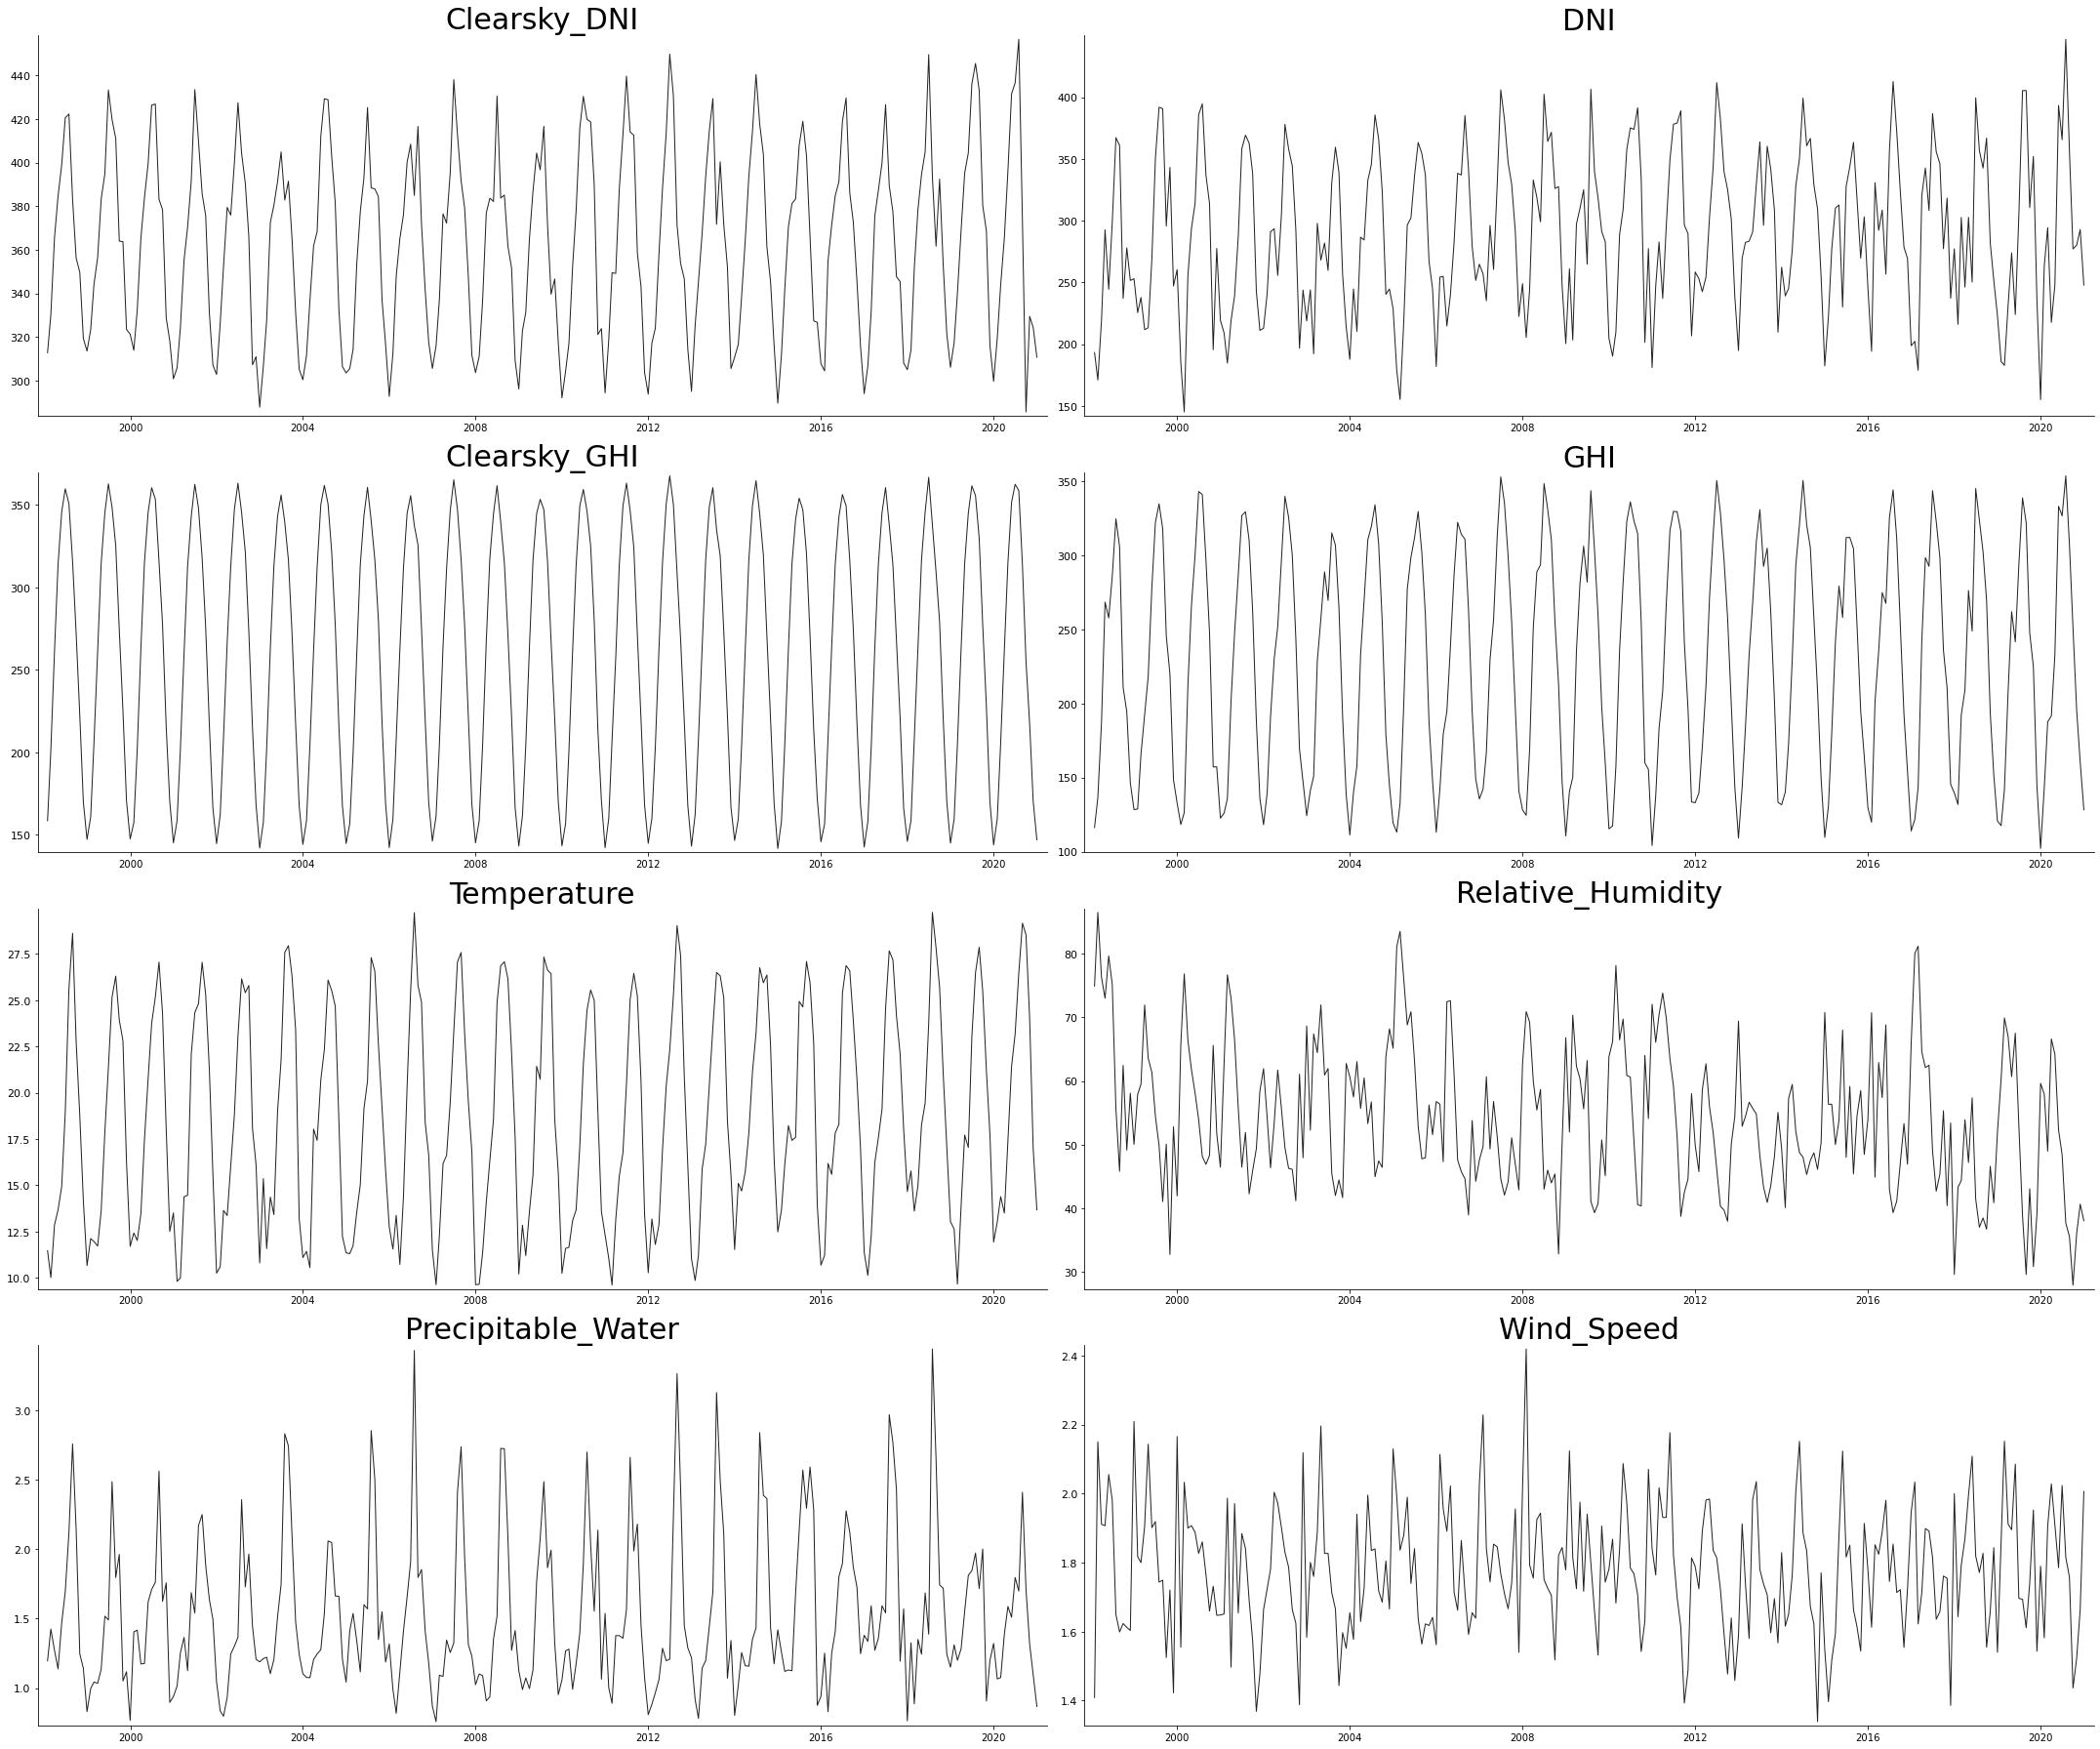

In [49]:
df_rs = df_rsm

# begin == 0, end == None -> include all data
begin = 0  # math.ceil(len(df_rs)*.90)
end = None  # math.ceil(len(df_rs) * 0.075)

df_plot = df_rs.iloc[begin:end]

# labels = list(zip((df_plot.index.year) , (df_plot.index.month)))
# xtickslabels = set([str(d[0])+"-"+str(d[1]) for d in labels])

fig, axes = plt.subplots(nrows=4, ncols=2)

for i, ax in enumerate(axes.flatten()):
    data = df_plot[df_plot.columns[i]]
    ax.plot(df_plot.index, data, color="#222222", linewidth=1)
    # ax.set_xticklabels(xtickslabels, rotation=45)
    ax.set_title(df.columns[i], fontsize=30)
    ax.spines["top"].set_alpha(0)
    ax.spines["right"].set_alpha(0)

plt.tight_layout()

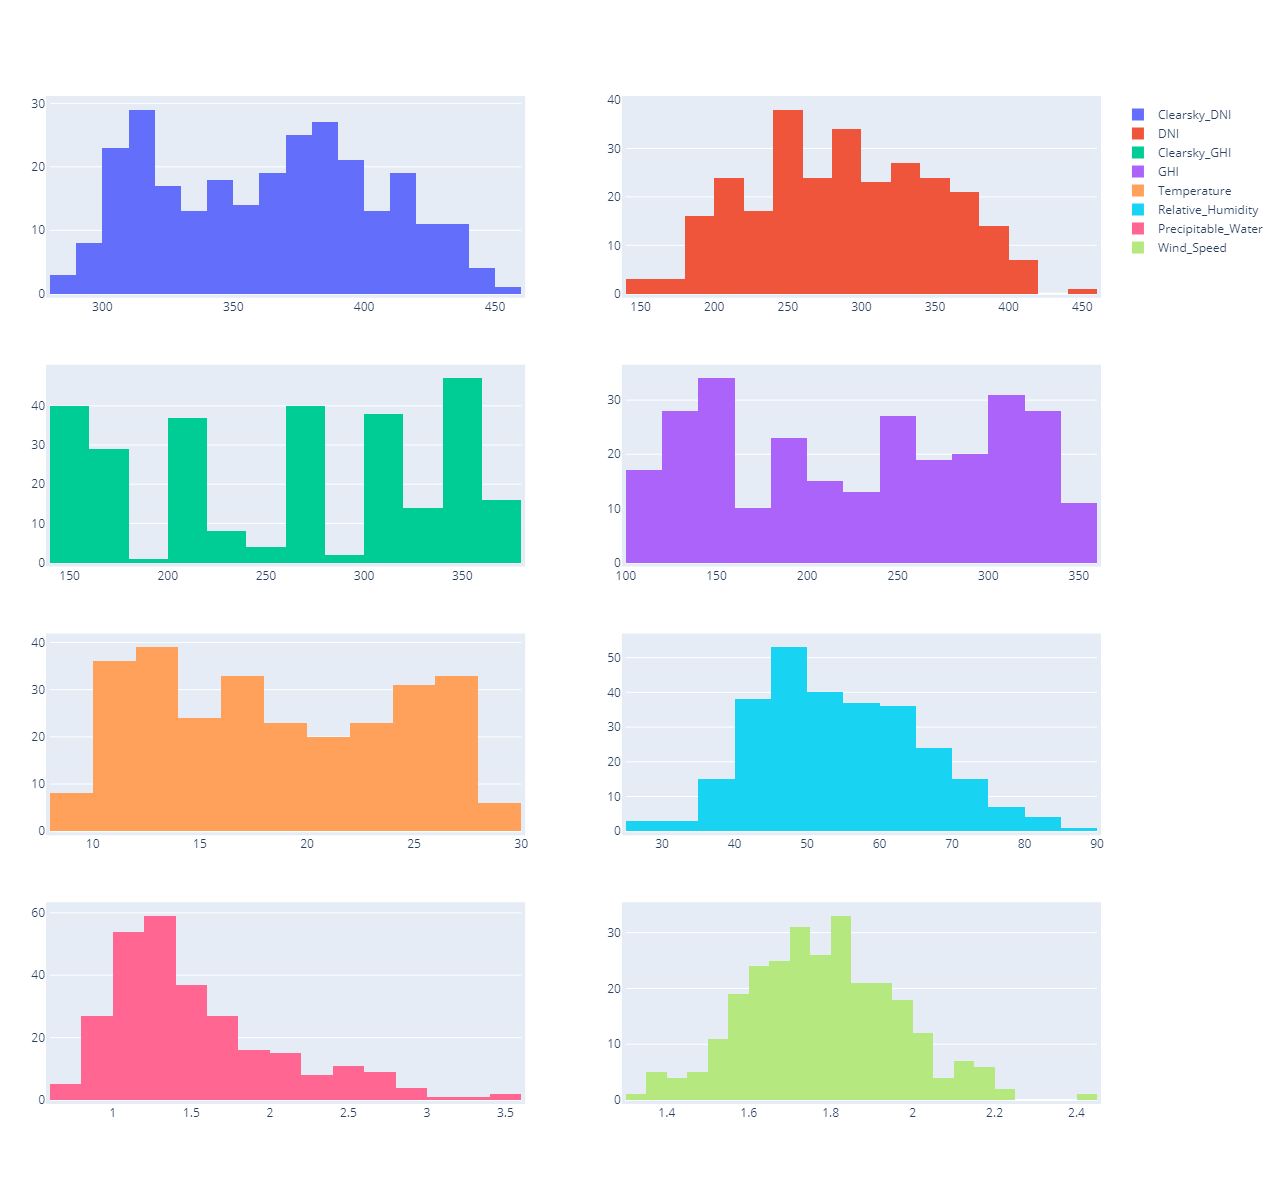

In [44]:
df_rs = df_rsm

# begin == 0, end == None -> include all data
begin = 0  # math.ceil(len(df_rs)*.90)
end = None  # math.ceil(len(df_rs) * 0.075)

df_plot = df_rs.iloc[begin:end]

rows, cols = 4, 2
trace = []

fig = make_subplots(rows=4, cols=2)

for idx, column in enumerate(columns):
    trace.append(go.Histogram(x=df_plot[column], name=column))

fig.update_layout(
    autosize=False,
    width=1300,
    height=1200,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ))

fig.append_trace(trace[0], 1, 1)
fig.append_trace(trace[1], 1, 2)
fig.append_trace(trace[2], 2, 1)
fig.append_trace(trace[3], 2, 2)
fig.append_trace(trace[4], 3, 1)
fig.append_trace(trace[5], 3, 2)
fig.append_trace(trace[6], 4, 1)
fig.append_trace(trace[7], 4, 2)

fig.show()

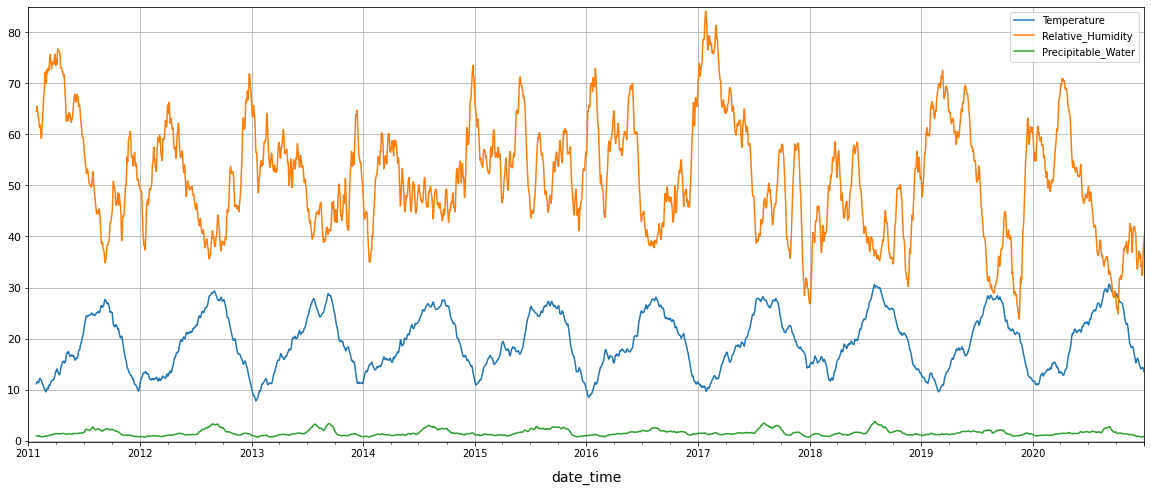

In [10]:
# # compares_ = ["Clearsky_DHI", "DHI"]
# compares_ = ["Wind_Speed", "Wind_Direction"]
compares_ = ["Temperature", "Relative_Humidity", "Precipitable_Water"]
# compares_ = ["Clearsky_GHI", "GHI"]
# compares_ = ["Clearsky_DNI", "DNI"]
# compares_ = ["GHI", "Relative_Humidity"]

# df.iloc[:35040][compares].rolling(365).mean().plot(figsize=(20, 8))
df_rsd.loc["2011-01-01":"2020-12-31"][compares_].rolling(28).mean().plot(figsize=(20, 8))
plt.grid()

In [11]:
df_rsm = df.resample("M").mean().reset_index(drop=False)
df_rsm.set_index("date_time", inplace=True)
# df_rsm

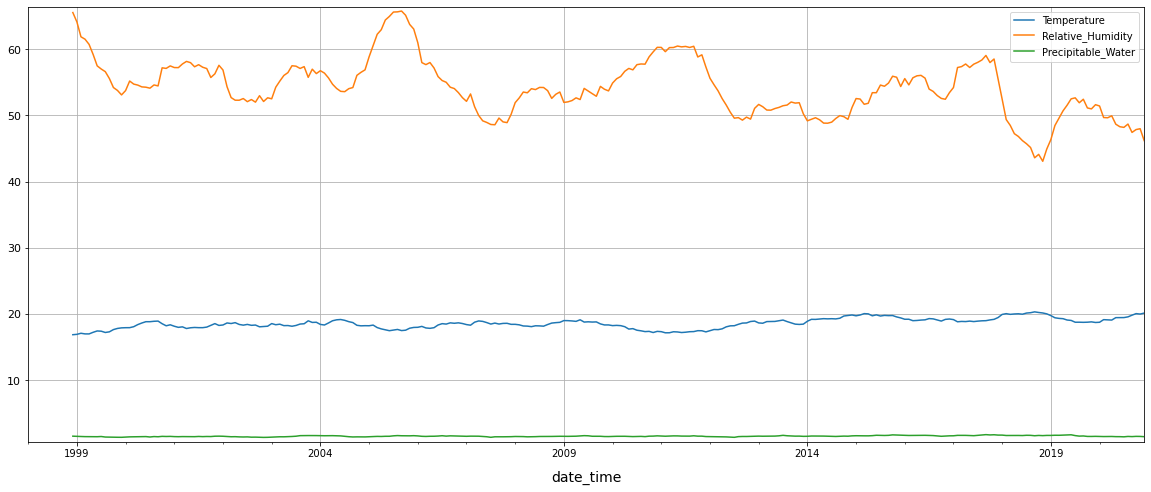

In [12]:
# # compares = ["Clearsky_DHI", "DHI"]
# # compares = ["Wind_Speed", "Wind_Direction"]

compares_CG = ["Clearsky_GHI", "GHI"]
compares_CD = ["Clearsky_DNI", "DNI"]
compares_HG = ["Relative_Humidity", "GHI"]
compares_HD = ["Relative_Humidity", "DNI"]
compares_THP = ["Temperature", "Relative_Humidity", "Precipitable_Water"]

df_rsm[compares_THP].rolling(12).mean().plot(figsize=(20, 8))
# df_rsm[compares_CG].rolling(12).mean().plot(figsize=(20, 8))
# df_rsm[compares_CD].rolling(12).mean().plot(figsize=(20, 8))
# df_rsm[compares_A].rolling(12).mean().plot(figsize=(20, 8))
# df_rsm[compares_G + compares_D].rolling(12).mean().plot(figsize=(20, 8))
plt.grid()

In [13]:
# df_diff = df_rsm.diff(periods=12).dropna()

df_diff = df_rsm.copy()
for column in columns:
    df_diff[column] = diff(df_diff[column], 1, 1, 12)

df_diff.dropna(inplace=True)

# df_diff.head(12)2)

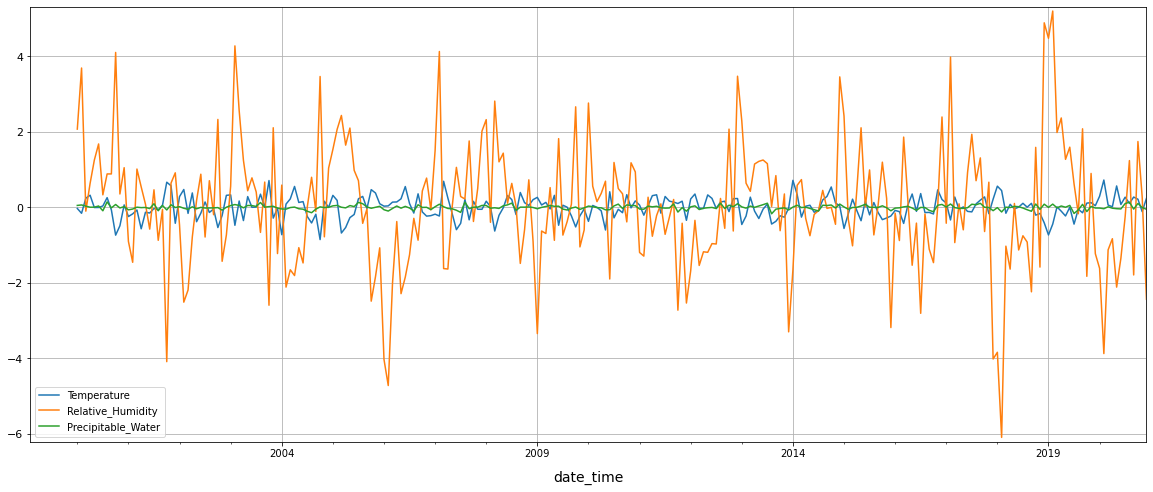

In [14]:
# # compares = ["Clearsky_DHI", "DHI"]
# # compares = ["Wind_Speed", "Wind_Direction"]

compares_HG = ["Relative_Humidity", "GHI"]
compares_CG = ["Clearsky_GHI", "GHI"]
compares_CD = ["Clearsky_DNI", "DNI"]
compares_THP = ["Temperature", "Relative_Humidity", "Precipitable_Water"]

df_diff[compares_THP].rolling(12).mean().plot(figsize=(20, 8))
# df_diff[compares_HG].rolling(12).mean().plot(figsize=(20, 8))
# df_diff[compares_CG].rolling(12).mean().plot(figsize=(20, 8))
# df_diff[compares_CD].rolling(12).mean().plot(figsize=(20, 8))
plt.grid()

In [19]:
adf_tests = []

for column in columns:
    adf_tests.append(adfuller(df_diff[column], autolag="AIC"))

for column, test in zip(columns, adf_tests):
    print(f"p-value: {test[1]}, lags: {test[2]} for {column}")

p-value: 5.172876851183793e-09, lags: 16 for Clearsky_DNI
p-value: 1.6690424186564485e-10, lags: 16 for DNI
p-value: 2.53847010895238e-09, lags: 16 for Clearsky_GHI
p-value: 4.835339506716251e-11, lags: 16 for GHI
p-value: 1.6361737605678158e-07, lags: 14 for Temperature
p-value: 2.3924221419536123e-10, lags: 16 for Relative_Humidity
p-value: 3.699476866649928e-12, lags: 16 for Precipitable_Water
p-value: 8.622377934789219e-10, lags: 15 for Wind_Speed


In [16]:
kpss_tests = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for column in columns:
        kpss_tests.append(kpss(df_diff[column], regression="ct", nlags="auto"))

for column, test in zip(columns, kpss_tests):
    print(f"p-value: {test[1]}, {test[2]} for {column}")

p-value: 0.1, 56 for Clearsky_DNI
p-value: 0.1, 55 for DNI
p-value: 0.015388893452602097, 101 for Clearsky_GHI
p-value: 0.1, 45 for GHI
p-value: 0.04998339708998931, 71 for Temperature
p-value: 0.1, 50 for Relative_Humidity
p-value: 0.1, 44 for Precipitable_Water
p-value: 0.1, 16 for Wind_Speed
